11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


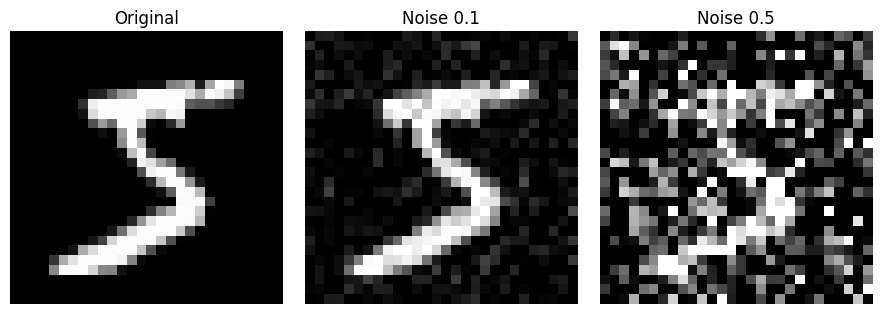

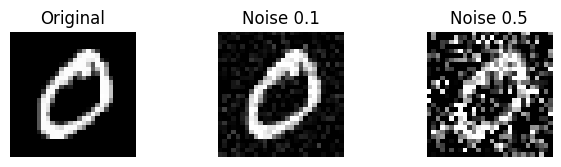

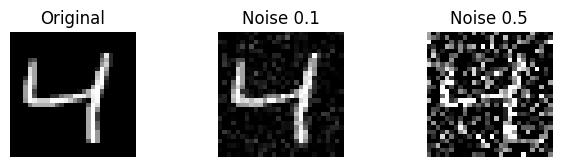

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)

# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):

    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
def build_encoder(input_shape = (28,28,1)):
    """
    Builds the encoder part of the convolutional autoencoder.
    Parameters:
    input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
    Returns:
    input_img (Keras Input): Input layer of the model.
    encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """

    input_img = Input(shape= input_shape, name="input")
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding = 'same', name='encoded')(x)

    return input_img, encoded

In [4]:
def build_decoder(encoded_input):
    """
        Builds the decoder part of the convolutional autoencoder.
        Parameters:
        encoded_input (Keras Tensor): The output from the encoder.
        Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and
        convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

In [5]:
def build_autoencoder():
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)

    autoencoder = Model(inputs=input_img, outputs=decoded_output, name='autoencoder')
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

    return autoencoder

In [6]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train with noisy input and clean target
history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 167s 349ms/step - loss: 0.2374 - val_loss: 0.1151
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 351ms/step - loss: 0.1133 - val_loss: 0.1080
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 337ms/step - loss: 0.1065 - val_loss: 0.1025
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 162s 346ms/step - loss: 0.1028 - val_loss: 0.1007
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 345ms/step - loss: 0.1008 - val_loss: 0.0993
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 346ms/step - loss: 0.0993 - val_loss: 0.0979
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 350ms/step - loss: 0.0983 - val_loss: 0.0977
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 347ms/step - loss: 0.0974 - val_loss: 0.0966
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 335ms/step - loss: 0.0968 - val_loss: 0.0962
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 334ms/step - loss: 0.0961 - val_loss: 0.0956


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


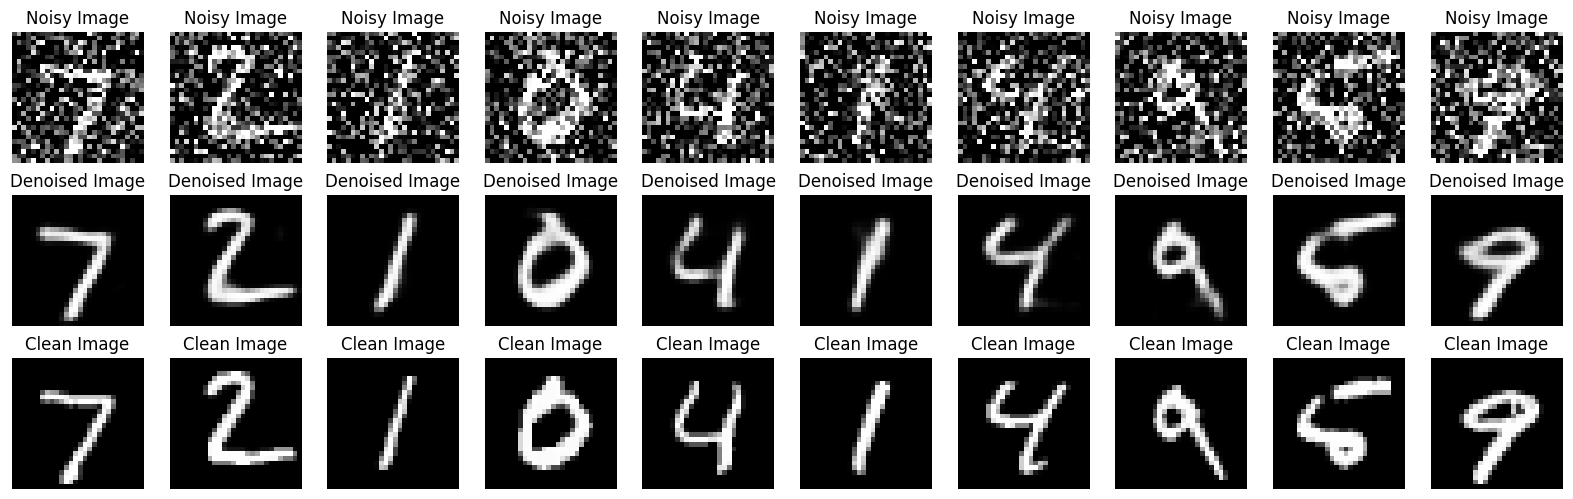

In [8]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')
    plt.show()
    # Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)